# Model for predicting flight delays 

This notebook will serve as a single notebook to run all the desired models on a given dataset

## 1. Initial Setup

#### Library

In [0]:
from pyspark import SparkContext
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType
from pyspark.sql import SQLContext, SparkSession

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import types
SEED = 7

import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

#### Spark Setting

In [0]:
# Enable for pretty viewing of tables
spark.conf.set("spark.sql.repl.eagerEval.enabled", True)

#### Project Directory

In [0]:
username = dbutils.notebook.entry_point.getDbutils().notebook().getContext().tags().apply('user')
userhome = 'dbfs:/user/' + username
print(userhome)
project_path = userhome + "/FinalProject/"
display(dbutils.fs.ls(project_path))

dbfs:/user/chitra.agastya@ischool.berkeley.edu

path,name,size
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/Chitra_feature_data/,Chitra_feature_data/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airline_singleday.parquet/,airline_singleday.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_3m_features_ext.parquet/,airlines_3m_features_ext.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_3m_full_features.parquet/,airlines_3m_full_features.parquet/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airlines_weather_data/,airlines_weather_data/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport-timezones.csv,airport-timezones.csv,439779
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges/,airport_edges/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_1_year/,airport_edges_1_year/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_3_month/,airport_edges_3_month/,0
dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/airport_edges_4_year/,airport_edges_4_year/,0


#### Variables

In [0]:
# Load training, validation and test data directories
train_dir = "train.parquet"
dev_dir = None
test_dir = None
mode = 'sample' #options are 'sample' or 'full'
outcome = 'is_delayed'
run = 'full' #options are 'basic' or 'full'

save_path = project_path + "Chitra_feature_data"
loadPipelineFromFile = False
savePipeline = False

if train_dir == 'train.parquet':
  mode = 'full'
  dev_dir = "dev.parquet"
  test_dir = "test.parquet"

print(f'Project Path: {project_path} mode:{mode}')

Project Path: dbfs:/user/chitra.agastya@ischool.berkeley.edu/FinalProject/ mode:full

# 2. Data

### 1.1 Load the Data

In [0]:
# Load the training data
def loadData(dirName, viewName):
  data = spark.read.option("header", "true").parquet(f'{project_path}{dirName}/*.parquet')
  data.createOrReplaceTempView(viewName)
  return data

train_data = loadData(train_dir, 'train_data')

In [0]:
display(train_data.limit(10))

origin,destination,year,month,day_of_month,day_of_week,crs_dep_time_utc,naive_crs_arr_time_utc,tail_num,op_carrier,distance,dep_blk,dep_del15,nas_delay,carrier_delay,weather_delay,security_delay,late_aircraft_delay,arr_delay,crs_arr_time_utc,arr_hour_utc,dep_hour_utc,hour,del_tail_num,equipment_delayed,dest_pagerank,src_pagerank,weight,avg_trips_per_day,avg_tp_per_day,avg_flights_per_day,avg_car_per_day,avg_car_flights_per_day,origin_2_wind_angle,origin_2_wind_speed,origin_2_ceiling,origin_2_visibility,origin_2_temperature,origin_2_dewpoint,origin_2_pressure,origin_3_wind_angle,origin_3_wind_speed,origin_3_ceiling,origin_3_visibility,origin_3_temperature,origin_3_dewpoint,origin_3_pressure,origin_4_wind_angle,origin_4_wind_speed,origin_4_ceiling,origin_4_visibility,origin_4_temperature,origin_4_dewpoint,origin_4_pressure,origin_5_wind_angle,origin_5_wind_speed,origin_5_ceiling,origin_5_visibility,origin_5_temperature,origin_5_dewpoint,origin_5_pressure,destination_2_wind_angle,destination_2_wind_speed,destination_2_ceiling,destination_2_visibility,destination_2_temperature,destination_2_dewpoint,destination_2_pressure,destination_3_wind_angle,destination_3_wind_speed,destination_3_ceiling,destination_3_visibility,destination_3_temperature,destination_3_dewpoint,destination_3_pressure,destination_4_wind_angle,destination_4_wind_speed,destination_4_ceiling,destination_4_visibility,destination_4_temperature,destination_4_dewpoint,destination_4_pressure,destination_5_wind_angle,destination_5_wind_speed,destination_5_ceiling,destination_5_visibility,destination_5_temperature,destination_5_dewpoint,destination_5_pressure
ABE,ATL,2015,1,30,5,2015-01-30T11:35:00.000+0000,2015-01-30T14:04:00.000+0000,N603AT,DL,692.0,6,0.0,null,null,null,null,null,-11.0,2015-01-30T14:04:00.000+0000,2015-01-30T14:00:00.000+0000,2015-01-30T11:00:00.000+0000,null,null,false,9.031150214803475,0.5947237603125133,0.09090909090909091,1.0,8,2.64,2,1.03,999.0,0.0,00792,011265,-2.2,-4.4,1011.9,25.0,1.5,00884,011265,-2.2,-4.4,1012.2,524.5,1.5,00945,008047,-2.2,-4.4,1013.0,999.0,0.0,00396,009656,-2.0,-4.4,1013.6,330.0,10.3,00732,016093,6.1,-0.6,1021.9,335.0,11.8,00792,016093,8.3,2.2,1021.1,320.0,9.3,00975,016093,10.6,3.9,1020.1,280.0,4.1,01067,016093,12.8,3.3,1019.1
ABE,ATL,2015,3,31,2,2015-03-31T16:02:00.000+0000,2015-03-31T18:10:00.000+0000,N916EV,EV,692.0,12,0.0,null,null,null,null,null,-18.0,2015-03-31T18:10:00.000+0000,2015-03-31T18:00:00.000+0000,2015-03-31T16:00:00.000+0000,null,null,false,9.031150214803475,0.5947237603125133,0.09090909090909091,1.02,8,2.64,4,1.7,270.0,2.6,02134,016093,5.6,-3.9,1012.3,999.0,1.5,22000,016093,5.0,-3.9,1012.5,999.0,0.0,22000,016093,4.4,-3.9,1012.6,310.0,6.2,22000,016093,3.3,-4.4,1012.4,210.0,3.1,22000,016093,16.1,3.9,1018.9,999.0,0.0,22000,016093,13.3,6.1,1018.7,220.0,1.5,22000,016093,9.4,4.4,1018.3,230.0,1.5,22000,016093,8.9,4.4,1017.8
ABE,ATL,2015,4,24,5,2015-04-24T10:40:00.000+0000,2015-04-24T12:47:00.000+0000,N906AT,DL,692.0,6,0.0,null,null,null,null,null,4.0,2015-04-24T12:47:00.000+0000,2015-04-24T12:00:00.000+0000,2015-04-24T10:00:00.000+0000,null,null,false,9.031150214803475,0.5947237603125133,0.09090909090909091,1.0,8,2.64,2,1.03,320.0,7.2,01280,016093,2.8,-6.7,1012.9,300.0,4.6,01341,016093,3.3,-6.1,1012.2,290.0,3.6,01402,016093,3.3,-6.7,1012.0,300.0,4.1,01524,016093,3.9,-6.7,1012.1,320.0,3.6,22000,016093,11.1,1.7,1016.0,320.0,4.1,22000,016093,12.2,1.7,1015.8,320.0,4.1,22000,016093,12.8,3.3,1016.0,320.0,4.1,22000,016093,13.3,5.0,1016.2
ABE,ATL,2015,5,7,4,2015-05-07T16:02:00.000+0000,2015-05-07T18:08:00.000+0000,N884AS,EV,692.0,12,0.0,null,null,null,null,null,-5.0,2015-05-07T18:08:00.000+0000,2015-05-07T18:00:00.000+0000,2015-05-07T16:00:00.000+0000,null,null,false,9.031150214803475,0.5947237603125133,0.09090909090909091,1.0,8,2.64,4,1.7,999.0,0.0,01676,016093,18.9,10.0,1024.0,999.0,0.0,01463,016093,16.7,10.6,1024.1,999.0,0.0,01402,016093,15.0,10.0,1023.7,60.0,1.5,01341,016093,13.9,10.0,1023.5,350.0,2.6,22000,016093,24.4

In [0]:
train_data.count()

Out[8]: 20409767

In [0]:
# Filter out any rows that have a departure delay of greater than 15 minutes that is attributed to security delay
display(train_data.where('dep_del15 == 1') \
        .where(f.col('security_delay') > 15) \
        .where(f.greatest(*[f.col(x) for x in ['carrier_delay', 'nas_delay', 'weather_delay', 'security_delay', 'late_aircraft_delay']]) == f.col('security_delay')) 
        )


origin,destination,year,month,day_of_month,day_of_week,crs_dep_time_utc,naive_crs_arr_time_utc,tail_num,op_carrier,distance,dep_blk,dep_del15,nas_delay,carrier_delay,weather_delay,security_delay,late_aircraft_delay,arr_delay,crs_arr_time_utc,arr_hour_utc,dep_hour_utc,hour,del_tail_num,equipment_delayed,dest_pagerank,src_pagerank,weight,avg_trips_per_day,avg_tp_per_day,avg_flights_per_day,avg_car_per_day,avg_car_flights_per_day,origin_2_wind_angle,origin_2_wind_speed,origin_2_ceiling,origin_2_visibility,origin_2_temperature,origin_2_dewpoint,origin_2_pressure,origin_3_wind_angle,origin_3_wind_speed,origin_3_ceiling,origin_3_visibility,origin_3_temperature,origin_3_dewpoint,origin_3_pressure,origin_4_wind_angle,origin_4_wind_speed,origin_4_ceiling,origin_4_visibility,origin_4_temperature,origin_4_dewpoint,origin_4_pressure,origin_5_wind_angle,origin_5_wind_speed,origin_5_ceiling,origin_5_visibility,origin_5_temperature,origin_5_dewpoint,origin_5_pressure,destination_2_wind_angle,destination_2_wind_speed,destination_2_ceiling,destination_2_visibility,destination_2_temperature,destination_2_dewpoint,destination_2_pressure,destination_3_wind_angle,destination_3_wind_speed,destination_3_ceiling,destination_3_visibility,destination_3_temperature,destination_3_dewpoint,destination_3_pressure,destination_4_wind_angle,destination_4_wind_speed,destination_4_ceiling,destination_4_visibility,destination_4_temperature,destination_4_dewpoint,destination_4_pressure,destination_5_wind_angle,destination_5_wind_speed,destination_5_ceiling,destination_5_visibility,destination_5_temperature,destination_5_dewpoint,destination_5_pressure


### 2.1 Preprocess and Split Data

We will be doing a time based split to make sure we have a training data, validation data to validate models and the test data,

In [0]:
def preProcessData(dff, outcome = 'is_delayed'):
  # filter out all delays related to security delays
  sec = dff.where('dep_del15 == 1') \
        .where(f.col('security_delay') > 15) \
        .where(f.greatest(*[f.col(x) for x in ['carrier_delay', 'nas_delay', 'weather_delay', 'security_delay', 'late_aircraft_delay']]) == f.col('security_delay'))
  
  dff = dff.subtract(sec)
  
  # Take care of unknown weather values
  # Convert pressure 9999 to null
  for col in [x for x in dff.columns if x.endswith('_pressure')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 9999, None).otherwise(f.col(col)))
    
  # Convert ceiling 99999 to None
  for col in [x for x in dff.columns if x.endswith('_ceiling')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 99999, None).otherwise(f.col(col)))
    
  # Convert wind_speed 999.9 to None
  for col in [x for x in dff.columns if x.endswith('_wind_speed')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 999.9, None).otherwise(f.col(col)))
    
  # Convert wind_speed 999.9 to None
  for col in [x for x in dff.columns if x.endswith('_wind_angle')]:
    dff = dff.withColumn(col, f.when(f.col(col) == 999, None).otherwise(f.col(col)))
  
  # Convert visibility and ceiling to integer values
  for col in [x for x in dff.columns if x.endswith('_visibility') or x.endswith('_ceiling')]:
    dff = dff.withColumn(col, dff[col].cast(IntegerType()))

  # Convert temperature and dewpoint to Kelvin by adding 273
  for col in [x for x in dff.columns if x.endswith('_temperature') or x.endswith('_dewpoint')]:
    dff = dff.withColumn(col, dff[col] + 273)
    
  # cast the equipment_delayed to numeric int
  dff = dff.withColumn('equipment_delayed', dff['equipment_delayed'].cast(IntegerType()))
  
  # create the outcome column
  dff = dff.withColumn(outcome, f.when(f.col('dep_del15') == 1, 1)
                                .otherwise(0)
                      )
  return dff

In [0]:
if mode == 'sample':
  temp = preProcessData(train_data)
  train_data = partitionData(temp, '2015-01-01', '2015-02-28')
  dev_data = partitionData(temp, '2015-03-01', '2015-03-15')
  test_data = partitionData(temp, '2015-03-16', '2015-03-31')
else:
  train_data = preProcessData(train_data).cache()
  dev_data = preProcessData(loadData(dev_dir, 'dev'))
  #test_data = preProcessData(loadData(test_dir, 'test'))

In [0]:
train_data.groupBy(outcome).count().show()

+----------+--------+
is_delayed| count|
+----------+--------+
 1| 3057117|
 0|17352650|
+----------+--------+

In [0]:
display(train_data.limit(10))

origin,destination,year,month,day_of_month,day_of_week,crs_dep_time_utc,naive_crs_arr_time_utc,tail_num,op_carrier,distance,dep_blk,dep_del15,nas_delay,carrier_delay,weather_delay,security_delay,late_aircraft_delay,arr_delay,crs_arr_time_utc,arr_hour_utc,dep_hour_utc,hour,del_tail_num,equipment_delayed,dest_pagerank,src_pagerank,weight,avg_trips_per_day,avg_tp_per_day,avg_flights_per_day,avg_car_per_day,avg_car_flights_per_day,origin_2_wind_angle,origin_2_wind_speed,origin_2_ceiling,origin_2_visibility,origin_2_temperature,origin_2_dewpoint,origin_2_pressure,origin_3_wind_angle,origin_3_wind_speed,origin_3_ceiling,origin_3_visibility,origin_3_temperature,origin_3_dewpoint,origin_3_pressure,origin_4_wind_angle,origin_4_wind_speed,origin_4_ceiling,origin_4_visibility,origin_4_temperature,origin_4_dewpoint,origin_4_pressure,origin_5_wind_angle,origin_5_wind_speed,origin_5_ceiling,origin_5_visibility,origin_5_temperature,origin_5_dewpoint,origin_5_pressure,destination_2_wind_angle,destination_2_wind_speed,destination_2_ceiling,destination_2_visibility,destination_2_temperature,destination_2_dewpoint,destination_2_pressure,destination_3_wind_angle,destination_3_wind_speed,destination_3_ceiling,destination_3_visibility,destination_3_temperature,destination_3_dewpoint,destination_3_pressure,destination_4_wind_angle,destination_4_wind_speed,destination_4_ceiling,destination_4_visibility,destination_4_temperature,destination_4_dewpoint,destination_4_pressure,destination_5_wind_angle,destination_5_wind_speed,destination_5_ceiling,destination_5_visibility,destination_5_temperature,destination_5_dewpoint,destination_5_pressure,is_delayed
ABQ,DFW,2016,9,11,7,2016-09-11T20:59:00.000+0000,2016-09-11T23:45:00.000+0000,N3MMAA,AA,569.0,14,1.0,0.0,0.0,27.0,0.0,82.0,109.0,2016-09-11T23:45:00.000+0000,2016-09-11T23:00:00.000+0000,2016-09-11T20:00:00.000+0000,null,null,0,10.026750186176836,1.2649364410677846,0.037037037037037035,1.0,56,5.4,6,4.99,230.0,3.6,22000,16093,298.0,283.6,1018.5,200.0,3.6,22000,16093,295.8,284.1,1019.1,200.0,3.6,22000,16093,293.6,284.7,1020.2,180.0,3.6,22000,16093,291.9,284.7,1020.6,999.0,1.5,22000,16093,301.3,285.8,1020.4,30.0,1.5,22000,16093,300.8,285.8,1021.5,160.0,2.1,22000,16093,298.6,286.3,1022.0,70.0,2.1,22000,16093,297.4,285.2,1022.2,1
ABQ,MSP,2017,11,3,5,2017-11-03T21:00:00.000+0000,2017-11-04T00:38:00.000+0000,N6707A,DL,981.0,15,0.0,null,null,null,null,null,-3.0,2017-11-04T00:38:00.000+0000,2017-11-04T00:00:00.000+0000,2017-11-03T21:00:00.000+0000,null,null,0,7.157564553451184,1.2649364410677846,0.037037037037037035,1.0,56,1.05,4,1.05,999.0,1.5,22000,16093,290.2,271.3,1017.6,190.0,1.5,22000,16093,288.6,271.3,1019.2,180.0,1.5,22000,16093,286.3,270.8,1019.7,170.0,1.5,22000,16093,284.7,271.3,1020.2,999.0,1.5,1981,16093,274.1,269.1,1030.2,50.0,3.1,2591,16093,273.6,268.6,1030.6,70.0,3.1,3048,16093,273.6,268.6,1030.8,50.0,3.1,3353,16093,273.0,268.0,1031.2,0
ABQ,PHX,2018,5,29,2,2018-05-29T18:55:00.000+0000,2018-05-29T19:10:00.000+0000,N749SW,WN,328.0,12,0.0,null,null,null,null,null,-15.0,2018-05-29T19:10:00.000+0000,2018-05-29T19:00:00.000+0000,2018-05-29T18:00:00.000+0000,null,null,0,4.926852396730475,1.2649364410677846,0.037037037037037035,1.08,56,7.23,32,5.69,999.0,1.5,22000,16093,294.1,269.1,1008.0,220.0,2.6,22000,16093,292.4,269.1,1008.0,130.0,2.6,22000,16093,290.2,268.0,1007.6,310.0,1.5,22000,16093,288.6,266.9,1007.4,120.0,2.1,22000,16093,301.9,276.9,1006.4,120.0,3.1,22000,16093,300.8,276.9,1006.3,120.0,2.6,22000,16093,298.6,275.8,1006.2,120.0,2.6,22000,16093,296.9,276.9,1005.8,0
ABQ,SAN,2018,5,13,7,2018-05-14T01:05:00.000+0000,2018-05-14T02:00:00.000+0000,N759GS,WN,628.0,19,1.0,0.0,151.0,0.0,0.0,0.0,151.0,2018-05-14T02:00:00.000+0000,2018-05-14T02:00:00.000+0000,2018-05-14T01:00:00.000+0000,null,null,0,2.8513668970209056,1.2649364410677846,0.037037037037037035,1.14,56,1.89,32,1.87,210.0,8.8,22000,16093,302.4,267.4,1004.7,190.0,9.3,22000,16093,301.9,269.7,1005.1,200.0,7.7,7620,16093,300.8,270.8,1006.0,180.0,7.2,220

### 1.2 Get the Features and Target Vars from Data

Create two versions of pipeline creation. We started off with a simple iterative pipeline creator *createStages()* and then attempted to parallelize sections of it in *createStages2()*. It appears that StringIndexer and StandardScaler can only be done sequentially but StandardScaler does work on a vector. The parallel version does work much faster than the sequential version.

In [0]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler, Imputer, StandardScaler, FeatureHasher, SQLTransformer
from pyspark.ml import Pipeline

def createStages(dff, outcome, run = 'full'):
  stages = []
  
  # Get the categorical columns
  categoricalColumns = ['origin', 'destination', 'month', 'day_of_month', 'day_of_week', 'op_carrier', 'dep_blk']
  if run != 'basic':
    categoricalColumns += ['equipment_delayed']
  for categoricalCol in categoricalColumns:
      stringIndexer = StringIndexer(inputCol = categoricalCol, outputCol = categoricalCol + 'Index').setHandleInvalid("keep")
      encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"], handleInvalid='keep')
      stages += [stringIndexer, encoder]

  label_stringIdx = StringIndexer(inputCol = outcome, outputCol = 'label').setHandleInvalid("keep")
  stages += [label_stringIdx]

  # Get numeric columns
  numericCols = ['distance', 'dest_pagerank', 'src_pagerank', 'weight']
  if run != 'basic':
      numericCols += [x for x in dff.columns if x.startswith('avg_')] + \
      [x for x in dff.columns if (x.startswith('origin_') or x.startswith('destination_')) and 'cavok' not in x]

  for i in numericCols:
    imputer = Imputer(inputCol=i, outputCol=i+"_Imputed", strategy='mean')
    assembler = VectorAssembler(inputCols=[i+"_Imputed"],outputCol=i+"_Vect", handleInvalid='keep')
    scaler = StandardScaler(inputCol=i+"_Vect", outputCol=i+"_Scaled")
    stages += [imputer, assembler, scaler]
    #stages += [imputer, assembler]

  print(numericCols)

  assemblerInputs = [c + "classVec" for c in categoricalColumns] + [c + "_Scaled" for c in numericCols]
  assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
  #assembler = FeatureHasher(inputCols=assemblerInputs, outputCol="features")
  stages += [assembler]
  return stages

# a more parallel attempt
def createStages2(dff, outcome, run = 'basic'):
  stages = []
  
  # Get the categorical columns
  categoricalColumnsNoAirports = ['month', 'day_of_month', 'day_of_week', 'op_carrier', 'dep_blk']
  # add equipement_delayed for non-basic runs
  if run != 'basic':
    categoricalColumnsNoAirports += ['equipment_delayed']
  # and our full set includes origin and destination for string indexing 
  filterColumns = ['origin', 'destination'] 
  categoricalColumns = filterColumns + categoricalColumnsNoAirports
  
  
  # index their strings. sadly, no parallel method for that
  stringIndexers = [StringIndexer(inputCol = col, outputCol = col + 'Index').setHandleInvalid("keep") for col in categoricalColumns]
  stages += stringIndexers
          
  # one-hot encode the categorical columns
  encoder = OneHotEncoder(inputCols=[col + 'Index' for col in categoricalColumnsNoAirports], \
                          outputCols=[col + "classVec" for col in categoricalColumnsNoAirports], \
                          handleInvalid='keep')
  stages += [encoder]
  
  # add the outcome label
  label_stringIdx = StringIndexer(inputCol = outcome, outputCol = 'label').setHandleInvalid("keep")
  stages += [label_stringIdx]

  # Get numeric columns
  numericCols = ['distance', 'dest_pagerank', 'src_pagerank', 'weight']
  if run != 'basic':
      numericCols += [x for x in dff.columns if x.startswith('avg_')] + \
      [x for x in dff.columns if (x.startswith('origin_') or x.startswith('destination_'))]
  
  # impute, vectorize and scale numeric columns
  imputedCols = [col+"_Imputed" for col in numericCols]
  imputer = Imputer(inputCols=numericCols, outputCols=imputedCols, strategy='mean')
  
  # from our runs, it looks like the parallel imputer might not have a deterministic output column order
  # make sure the resulting columns are in a defined order
  cols = ['label', 'originIndex', 'destinationIndex'] + [c+"classVec" for c in categoricalColumnsNoAirports] + imputedCols
  col_string = ','.join(cols)
  feature_projector = SQLTransformer(statement=f"SELECT {col_string} FROM __THIS__")
  
  # now convert some of this into a vector and scale its dimensions independently
  assembler = VectorAssembler(inputCols=imputedCols,outputCol="numeric_vect", handleInvalid='keep')
  scaler = StandardScaler(inputCol="numeric_vect", outputCol="numeric_scaled")
  stages += [imputer, feature_projector, assembler, scaler]
  
  # put all the features together
  feature_assembler = VectorAssembler(inputCols=[c + "classVec" for c in categoricalColumnsNoAirports] + ["numeric_scaled"], outputCol="features")
  hash_assembler = VectorAssembler(inputCols=["originIndex", "destinationIndex", "numeric_scaled"], outputCol="hash_vector")
  # final projection of columns, review this carefully
  outputCols = ['label', 'originIndex', 'destinationIndex', 'hash_vector', 'numeric_scaled', 'features'] + [c + "classVec" for c in categoricalColumnsNoAirports]
  col_string = ','.join(outputCols)
  final_projector = SQLTransformer(statement=f"SELECT {col_string} FROM __THIS__")
    
  stages += [feature_assembler, hash_assembler, final_projector]
  
  return stages

NOTE: The estimator is not added to the pipleine as we dont want to replicate pipeline creation for eash estimator. We are training a baseline model on four estimators and all four will be using the same feature set, which has been created using our pipeline. This feature will then be fed into each estimator

In [0]:
# Create the pipeline and fit to the training data
stages = createStages2(train_data, outcome, run)
pipeline = Pipeline(stages = stages)
pipelineModel = pipeline.fit(train_data)

NOTE: We are not transforming test data here as this is just for picking our model of choice. We will be working with our validation data for evaluating the model.

In [0]:
# Transform the train, dev and test data with the pipeline
def transformData (d, pl_model, cols):
  return pl_model.transform(d).select(cols)

# Transform the training, dev and test data
selectedCols = ['label', 'features']
train = transformData(train_data, pipelineModel, selectedCols).cache()
dev = transformData(dev_data, pipelineModel, selectedCols)
#test = transformData(test_data, pipelineModel, selectedCols)

train.printSchema()

root
-- label: double (nullable = false)
-- features: vector (nullable = true)

In [0]:
display(train.limit(10))

label,features
1.0,"Map(vectorType -> sparse, length -> 161, indices -> List(5, 25, 50, 55, 84, 93, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9340129324433625, 3.348983749904195, 0.4225702269847837, 0.42660258466388484, 2.1010181996947135, 0.20244265371923303, 0.794003270756373, 0.04200654616490666, 1.553843889939135, 0.7949127106729929, 0.12920329022905133, 2.274274627598289, 1.4307090382262042, 18.030074215604056, 13.906847174450204, 1.5072651118679015, 0.6805232136298561, 0.12910506820166304, 2.2679145951453643, 1.393907506526687, 17.831852177559753, 13.768239018205145, 1.509948538103443, 0.6722403453512752, 0.13094775853012183, 2.262384776625527, 1.3777697745565005, 17.421156830622603, 13.623921043532421, 1.5167942517098156, 0.5991448873117582, 0.13341441895427095, 2.2574044838076297, 1.3278233035458673, 17.081037640069795, 13.499365636705011, 1.5153250792921473, 3.476185033943208, 0.05479222929973235, 2.2764075011331095, 1.5868235253349399, 19.093917292582304, 14.582699348723692, 1.5181388734251788, 0.1029077463902436, 0.054858565202609164, 2.2696585234127076, 1.4788249875284447, 18.584043759516778, 14.32492067852824, 1.5231927863083154, 0.5417722864753765, 0.07686369301892407, 2.2631592275547057, 1.4009383325560543, 18.165172331640225, 14.113663641570346, 1.5235758175224536, 0.23478390655317516, 0.07629372460492102, 2.2588784721021304, 1.359988201453775, 17.686096659676544, 13.797419262078362, 1.5253672742823194))"
0.0,"Map(vectorType -> sparse, length -> 161, indices -> List(6, 39, 45, 54, 80, 93, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.6103105214884685, 2.3906616733550217, 0.4225702269847837, 0.42660258466388484, 2.1010181996947135, 0.20244265371923303, 0.15438952486929475, 0.02800436410993777, 0.3269611391655494, 3.4526860780970425, 0.053834704262104724, 2.274274627598289, 1.4307090382262042, 17.558146098551333, 13.303694070621793, 1.5059332133890788, 0.6464970529483633, 0.0537937784173596, 2.2679145951453643, 1.393907506526687, 17.39781115092544, 13.147917091302554, 1.5100967030075843, 0.6050163108161477, 0.05456156605421743, 2.262384776625527, 1.3777697745565005, 16.988001364466115, 12.958755948677837, 1.5160508708767877, 0.5658590602388828, 0.05558934123094623, 2.2574044838076297, 1.3278233035458673, 16.65971708163025, 12.863989804137935, 1.5147311835134711, 3.476185033943208, 0.05479222929973235, 0.2049801481702132, 1.5868235253349399, 17.370204878515796, 13.730596202734588, 1.5327191958081334, 0.17151291065040597, 0.11337436808539228, 0.2673038742801057, 1.4788249875284447, 16.903571717432815, 13.462819084159152, 1.5367621004105236, 0.23702537533297718, 0.1134654515993641, 0.31355042389030646, 1.4009383325560543, 16.644310615997206, 13.241110912070539, 1.53669466996296, 0.16770279039512512, 0.1126240696548834, 0.34427361440720194, 1.359988201453775, 16.235051742070265, 12.965316838138154, 1.5387974302875442))"
0.0,"Map(vectorType -> sparse, length -> 161, indices -> List(2, 41, 49, 53, 79, 93, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160), values -> List(1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.53841167283202

# 2. Classifiers

In [0]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics

def trainModel (type, labelCol, featuresCol, data):
    classifier = None
    model = None
    if type == 'DecisionTree':
        classifier = DecisionTreeClassifier(labelCol= labelCol, featuresCol = featuresCol)
    elif type == 'RandomForest':
        classifier = RandomForestClassifier(featuresCol = featuresCol, labelCol = labelCol, numTrees = 25, maxDepth = 12)
    elif type == 'GBT':
        classifier = GBTClassifier(featuresCol = featuresCol, labelCol = labelCol) #, maxIter = 20, maxDepth = 8, maxBins = 60 
    elif type == 'Logistic':
        classifier = LogisticRegression(featuresCol = featuresCol, labelCol = labelCol) #, maxIter= 25, regParam= 0.3, elasticNetParam= 0.8) 
    
    if classifier:
        model = classifier.fit(data)
        
    return model
        
def predictAndEvaluate (data, model, evaluate = False):
    predictions = None
    if model:
        predictions = model.transform(data)
        
    if predictions and evaluate:
        evaluator = BinaryClassificationEvaluator(labelCol="label")
        print("Test Area Under ROC: {}".format(str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"}))))
        print("Test Area Under PR: {}".format(str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"}))))

        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
        accuracy = evaluator.evaluate(predictions)
        print("Accuracy = %g " % (accuracy))
        print("Test Error = %g " % (1.0 - accuracy))

        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
        precision = evaluator.evaluate(predictions)
        print("F1-Score = %g " % (precision))

        evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
        precision = evaluator.evaluate(predictions)
        print("Precision = %g " % (precision))
        
    if predictions:
      evaluateModel(predictions.select('prediction', 'label').rdd.map(tuple), [0,1])

    return predictions

def evaluateModel(predictionAndLabels, labels):
    # Instantiate metrics object
    metrics = MulticlassMetrics(predictionAndLabels)
    
    # Confusion Matrix
    print("Confusion matrix:")
    print(metrics.confusionMatrix().toArray())
    plot_confusion_matrix(metrics.confusionMatrix().toArray(), target_names = ['On-time', 'Delayed'])

    # Overall statistics
    precision = metrics.precision(1.0)
    recall = metrics.recall(1.0)
    f1Score = metrics.fMeasure(1.0)
    print("Summary Stats")
    print("Precision = %s" % precision)
    print("Recall = %s" % recall)
    print("F1 Score = %s" % f1Score)

    # Statistics by class
    for label in sorted(labels):
        print("Class %s precision = %s" % (label, metrics.precision(label)))
        print("Class %s recall = %s" % (label, metrics.recall(label)))
        print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(float(label), beta=1.0)))

    # Weighted stats
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

## 2.1 Decision Tree Classifier

Confusion matrix:
[[1918864. 3586.]
 [ 332775. 9243.]]

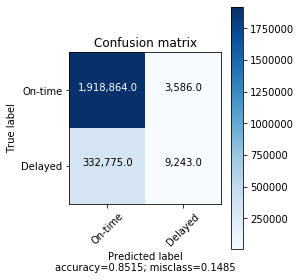

Summary Stats
Precision = 0.7204770441967417
Recall = 0.027024893426661756
F1 Score = 0.052095691946106346
Class 0 precision = 0.8522076585100897
Class 0 recall = 0.9981346719030404
Class 0 F1 Measure = 0.9194169074976599
Class 1 precision = 0.7204770441967417
Class 1 recall = 0.027024893426661756
Class 1 F1 Measure = 0.052095691946106346
Weighted recall = 0.8514613586944041
Weighted precision = 0.8323114880867397
Weighted F(1) Score = 0.7884194866904278
Weighted F(0.5) Score = 0.7630311881437621
Weighted false positive rate = 0.8263017933647021

In [0]:
dt = trainModel('DecisionTree', 'label', 'features', train)
predictions_dt = predictAndEvaluate(dev, dt)

**Feature Importance**

Lets extract the features that the decision tree deems important. We can see from below output that only 13 of the 161 features are critical in making decision for this SDT configuration

In [0]:
dt.featureImportances

Out[20]: SparseVector(161, {8: 0.0, 53: 0.016, 74: 0.0017, 75: 0.0018, 81: 0.0003, 94: 0.6171, 99: 0.0056, 100: 0.0075, 107: 0.045, 109: 0.0248, 121: 0.0017, 123: 0.2784, 143: 0.0})

In [0]:
def ExtractFeatureImp(featureImp, dataset, featuresCol):
    list_extract = []
    
    numericCols = ['distance', 'dest_pagerank', 'src_pagerank', 'weight'] + \
      [x for x in train_data.columns if x.startswith('avg_')] + \
      [x for x in train_data.columns if (x.startswith('origin_') or x.startswith('destination_'))]
    
    for i in dataset.schema["features"].metadata["ml_attr"]["attrs"]:
        list_extract = list_extract + dataset.schema[featuresCol].metadata["ml_attr"]["attrs"][i]
    varlist = pd.DataFrame(list_extract)
    varlist['score'] = varlist['idx'].apply(lambda x: featureImp[x])
    varlist['friendly_name'] = varlist['idx'].apply(lambda x: numericCols[x - 96] if x > 95 else '')
    return(varlist.sort_values('score', ascending = False))

In [0]:
ExtractFeatureImp(dt.featureImportances, train, "features").head(50)

Out[22]:

,idx,name,score
159,94,equipment_delayedclassVec_1,0.617135
27,123,numeric_scaled_27,0.278376
11,107,numeric_scaled_11,0.045038
13,109,numeric_scaled_13,0.024809
118,53,op_carrierclassVec_WN,0.016042
4,100,numeric_scaled_4,0.007501
3,99,numeric_scaled_3,0.005558
140,75,dep_blkclassVec_8,0.001817
139,74,dep_blkclassVec_7,0.001738
25,121,numeric_scaled_25,0.001666


## 2.2 Random Forest Classifier

Confusion matrix:
[[1919185. 3265.]
 [ 332923. 9095.]]

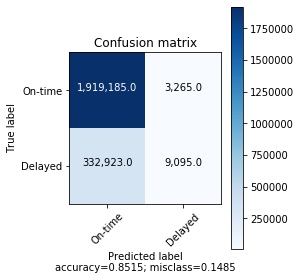

Summary Stats
Precision = 0.73584142394822
Recall = 0.026592167663690214
F1 Score = 0.05132937146211108
Class 0 precision = 0.8521727199583679
Class 0 recall = 0.9983016463367058
Class 0 F1 Measure = 0.9194674022974408
Class 1 precision = 0.73584142394822
Class 1 recall = 0.026592167663690214
Class 1 F1 Measure = 0.05132937146211108
Weighted recall = 0.851537756329522
Weighted precision = 0.8346024132908421
Weighted F(1) Score = 0.7883466123237084
Weighted F(0.5) Score = 0.7628274645242854
Weighted false positive rate = 0.826643942329126

In [0]:
rf = trainModel('RandomForest', 'label', 'features', train)
predictions_rf = predictAndEvaluate(dev, rf)

## 2.3 Gradient Boost Classifier

Confusion matrix:
[[1918444. 4006.]
 [ 331675. 10343.]]

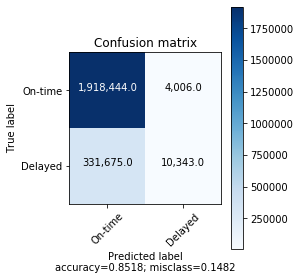

Summary Stats
Precision = 0.7208167816572584
Recall = 0.030241098421720493
F1 Score = 0.0580469010879234
Class 0 precision = 0.8525966848864438
Class 0 recall = 0.9979162006814222
Class 0 F1 Measure = 0.9195505215132452
Class 1 precision = 0.7208167816572584
Class 1 recall = 0.030241098421720493
Class 1 F1 Measure = 0.0580469010879234
Weighted recall = 0.8517616499769483
Weighted precision = 0.8326930700229793
Weighted F(1) Score = 0.7894317716564896
Weighted F(0.5) Score = 0.7650924814198294
Weighted false positive rate = 0.8236043508738057

In [0]:
gbt = trainModel('GBT', 'label', 'features', train)
predictions_gbt = predictAndEvaluate(dev, gbt)

In [0]:
ExtractFeatureImp(gbt.featureImportances, train, "features").head(50)

Out[17]:

,idx,name,score,friendly_name
119,54,op_carrierclassVec_DL,0.055135,
138,73,dep_blkclassVec_6,0.044485,
45,141,numeric_scaled_45,0.042756,destination_3_wind_speed
12,108,numeric_scaled_12,0.042322,origin_2_visibility
154,89,dep_blkclassVec_0,0.038495,
140,75,dep_blkclassVec_8,0.037314,
40,136,numeric_scaled_40,0.035734,destination_2_visibility
60,156,numeric_scaled_60,0.034271,destination_5_ceiling
1,97,numeric_scaled_1,0.030696,dest_pagerank
55,151,numeric_scaled_55,0.027734,destination_4_temperature


## 2.4 Basic Logistic Regression

Confusion matrix:
[[1918152. 4298.]
 [ 331971. 10047.]]

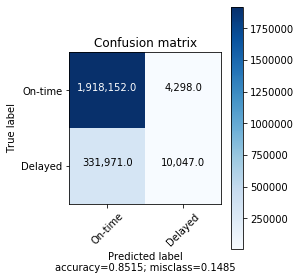

Summary Stats
Precision = 0.700383408853259
Recall = 0.029375646895777416
F1 Score = 0.056386325179662314
Class 0 precision = 0.8524653985582121
Class 0 recall = 0.99776431116544
Class 0 F1 Measure = 0.9194096783926848
Class 1 precision = 0.700383408853259
Class 1 recall = 0.029375646895777416
Class 1 F1 Measure = 0.056386325179662314
Weighted recall = 0.8515019863385132
Weighted precision = 0.8294954215239115
Weighted F(1) Score = 0.7890613929591034
Weighted F(0.5) Score = 0.764419018792028
Weighted false positive rate = 0.8243620282772957

In [0]:
lr_model = trainModel('Logistic', 'label', 'features', train)
predictions_lr = predictAndEvaluate(dev, lr_model)